Convert Red Mask Images To Binary Images

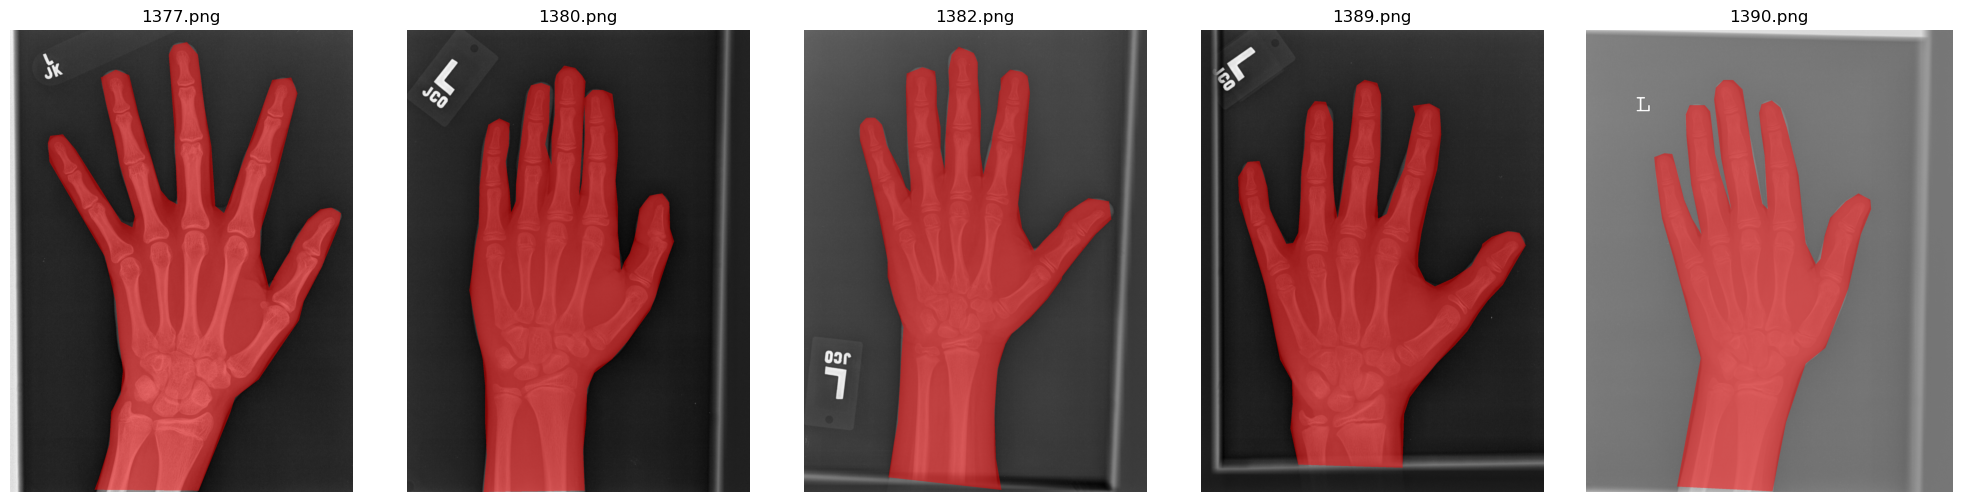

In [5]:
import os
from PIL import Image
import matplotlib.pyplot as plt

# Function to display up to 5 images from a specific folder side by side
def display_images_from_folder(folder_path, max_images=5):
    # Get a list of all files in the folder
    files = os.listdir(folder_path)
    
    # Filter out image files (assuming they have typical image extensions)
    image_extensions = ['.png', '.jpg', '.jpeg', '.gif', '.bmp']
    image_files = [f for f in files if os.path.splitext(f)[1].lower() in image_extensions]
    
    # Limit the number of images to display
    image_files = image_files[:max_images]
    
    # Create a figure to display images
    num_images = len(image_files)
    plt.figure(figsize=(min(num_images * 4, 20), 5))  # Adjust figure size based on the number of images
    
    # Loop through image files and display each one
    for i, image_file in enumerate(image_files):
        image_path = os.path.join(folder_path, image_file)
        image = Image.open(image_path)
        
        plt.subplot(1, num_images, i + 1)  # Create a subplot for each image
        plt.imshow(image)
        plt.axis('off')  # Hide axis
        plt.title(image_file)  # Set the title of the subplot
    
    # Adjust layout and show the images
    plt.tight_layout()
    plt.show()

# Replace 'your_folder_path_here' with the path to your folder
folder_path = 'masks'
display_images_from_folder(folder_path, max_images=5)


In [2]:
import cv2
import numpy as np
import os

def convert_to_binary(input_folder, output_folder):
    # Create output folder if it doesn't exist
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    
    # Loop through all files in the input folder
    for filename in os.listdir(input_folder):
        if filename.endswith(('.png', '.jpg', '.jpeg')):  # Add or remove file extensions as needed
            # Read the image
            img_path = os.path.join(input_folder, filename)
            img = cv2.imread(img_path)
            
            # Convert to HSV color space
            hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
            
            # Define range for red color
            lower_red = np.array([0, 120, 70])
            upper_red = np.array([10, 255, 255])
            mask1 = cv2.inRange(hsv, lower_red, upper_red)
            
            lower_red = np.array([170, 120, 70])
            upper_red = np.array([180, 255, 255])
            mask2 = cv2.inRange(hsv, lower_red, upper_red)
            
            # Combine masks
            mask = mask1 + mask2
            
            # Create binary image (255 for mask, 0 for background)
            binary = np.zeros(img.shape[:2], dtype=np.uint8)
            binary[mask > 0] = 255
            
            # Save the result
            output_path = os.path.join(output_folder, f'binary_{filename}')
            cv2.imwrite(output_path, binary)
            
            print(f'Processed: {filename}')

# Usage
input_folder = 'path/to/input/folder'
output_folder = 'path/to/output/folder'
#convert_to_binary(input_folder, output_folder)

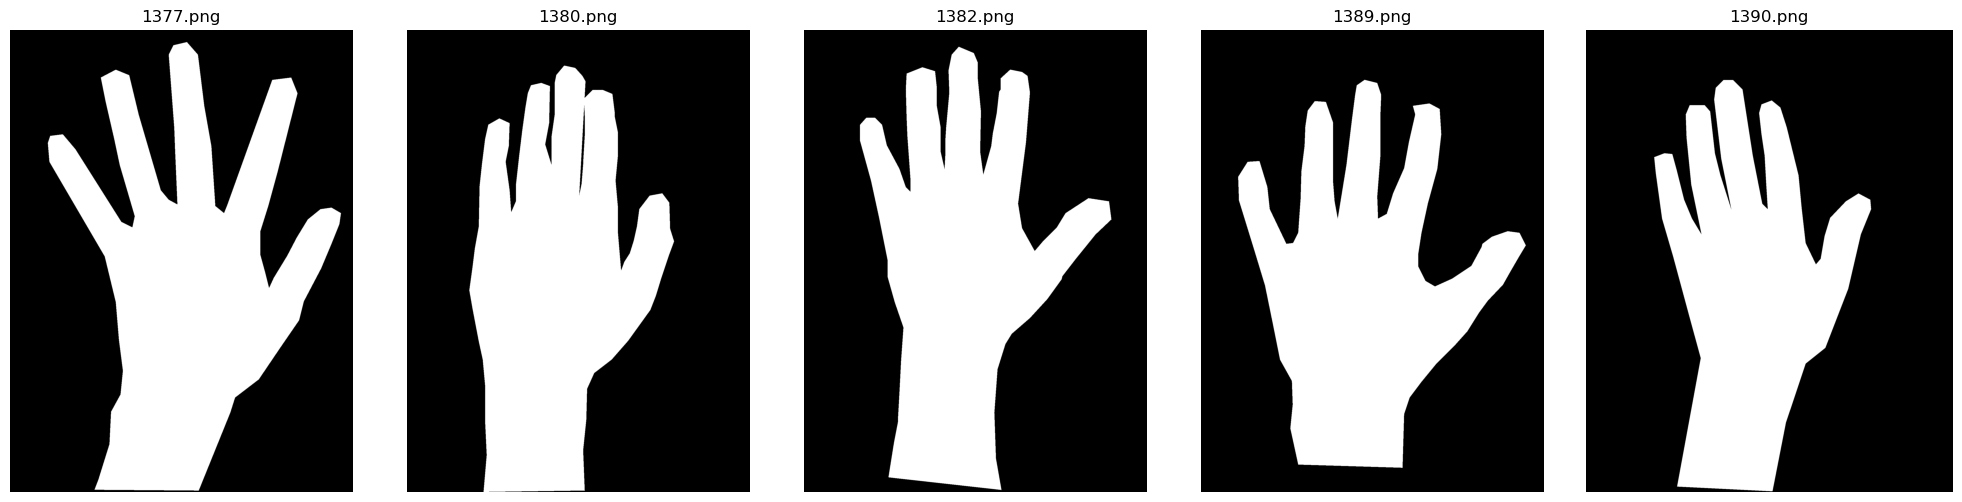

In [11]:
import os
from PIL import Image
import matplotlib.pyplot as plt

# Function to display specific images from a folder in grayscale side by side
def display_specific_images_from_folder(folder_path, image_names):
    # Create a figure to display images
    num_images = len(image_names)
    plt.figure(figsize=(min(num_images * 4, 20), 5))  # Adjust figure size based on the number of images
    
    # Loop through specified image names and display each one
    for i, image_name in enumerate(image_names):
        image_path = os.path.join(folder_path, image_name)
        if os.path.exists(image_path):
            image = Image.open(image_path).convert('L')  # Convert to grayscale
            
            plt.subplot(1, num_images, i + 1)  # Create a subplot for each image
            plt.imshow(image, cmap='gray')  # Display in grayscale
            plt.axis('off')  # Hide axis
            plt.title(image_name)  # Set the title of the subplot
        else:
            print(f"Image {image_name} not found in the folder.")
    
    # Adjust layout and show the images
    plt.tight_layout()
    plt.show()

# Replace 'your_folder_path_here' with the path to your folder
folder_path = 'masks binary'

# List of specific image filenames
image_names = ['1377.png', '1380.png', '1382.png', '1389.png', '1390.png']

display_specific_images_from_folder(folder_path, image_names)


Create a Model for Segmentation

In [12]:
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
import cv2
import os
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define U-Net model
def unet_model(input_size=(128, 128, 1)):
    inputs = layers.Input(input_size)
    
    # Encoder (Downsampling)
    conv1 = layers.Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = layers.Conv2D(64, 3, activation='relu', padding='same')(conv1)
    pool1 = layers.MaxPooling2D(pool_size=(2, 2))(conv1)
    
    conv2 = layers.Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = layers.Conv2D(128, 3, activation='relu', padding='same')(conv2)
    pool2 = layers.MaxPooling2D(pool_size=(2, 2))(conv2)
    
    conv3 = layers.Conv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = layers.Conv2D(256, 3, activation='relu', padding='same')(conv3)
    pool3 = layers.MaxPooling2D(pool_size=(2, 2))(conv3)
    
    # Bridge
    conv4 = layers.Conv2D(512, 3, activation='relu', padding='same')(pool3)
    conv4 = layers.Conv2D(512, 3, activation='relu', padding='same')(conv4)
    
    # Decoder (Upsampling)
    up5 = layers.UpSampling2D(size=(2, 2))(conv4)
    up5 = layers.concatenate([up5, conv3])
    conv5 = layers.Conv2D(256, 3, activation='relu', padding='same')(up5)
    conv5 = layers.Conv2D(256, 3, activation='relu', padding='same')(conv5)
    
    up6 = layers.UpSampling2D(size=(2, 2))(conv5)
    up6 = layers.concatenate([up6, conv2])
    conv6 = layers.Conv2D(128, 3, activation='relu', padding='same')(up6)
    conv6 = layers.Conv2D(128, 3, activation='relu', padding='same')(conv6)
    
    up7 = layers.UpSampling2D(size=(2, 2))(conv6)
    up7 = layers.concatenate([up7, conv1])
    conv7 = layers.Conv2D(64, 3, activation='relu', padding='same')(up7)
    conv7 = layers.Conv2D(64, 3, activation='relu', padding='same')(conv7)
    
    outputs = layers.Conv2D(1, 1, activation='sigmoid')(conv7)
    
    model = models.Model(inputs=inputs, outputs=outputs)
    return model

def extract_patches(image, mask, patch_size=128, stride=64):
    patches = []
    mask_patches = []
    h, w = image.shape[:2]
    
    for y in range(0, h-patch_size+1, stride):
        for x in range(0, w-patch_size+1, stride):
            patch = image[y:y+patch_size, x:x+patch_size]
            mask_patch = mask[y:y+patch_size, x:x+patch_size]
            patches.append(patch)
            mask_patches.append(mask_patch)
    
    return np.array(patches), np.array(mask_patches)

def load_and_patch_data(image_dir, mask_dir, patch_size=128, stride=64):
    all_patches = []
    all_mask_patches = []
    
    for img_name in os.listdir(image_dir):
        img_path = os.path.join(image_dir, img_name)
        mask_path = os.path.join(mask_dir, img_name)
        
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        
        patches, mask_patches = extract_patches(img, mask, patch_size, stride)
        
        all_patches.extend(patches)
        all_mask_patches.extend(mask_patches)
    
    return np.array(all_patches), np.array(all_mask_patches)

def augment_data(images, masks):
    datagen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.1,
        height_shift_range=0.1,
        zoom_range=0.1,
        horizontal_flip=True,
        fill_mode='nearest')
    
    img_gen = datagen.flow(images, batch_size=len(images), seed=42)
    mask_gen = datagen.flow(masks, batch_size=len(masks), seed=42)
    
    augmented_images = next(img_gen)
    augmented_masks = next(mask_gen)
    
    return np.concatenate([images, augmented_images]), np.concatenate([masks, augmented_masks])

def train_patch_unet():
    # Load and patch data
    patches, mask_patches = load_and_patch_data('path/to/image/dir', 'path/to/mask/dir')
    
    # Normalize
    patches = patches / 255.0
    mask_patches = mask_patches / 255.0
    
    # Augment data
    patches, mask_patches = augment_data(patches, mask_patches)
    
    # Split data
    X_train, X_val, y_train, y_val = train_test_split(patches, mask_patches, test_size=0.2, random_state=42)
    
    # Reshape for model input
    X_train = X_train.reshape((-1, 128, 128, 1))
    X_val = X_val.reshape((-1, 128, 128, 1))
    y_train = y_train.reshape((-1, 128, 128, 1))
    y_val = y_val.reshape((-1, 128, 128, 1))
    
    # Create and compile model
    model = unet_model(input_size=(128, 128, 1))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    # Train model
    model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=32)
    
    return model

def predict_full_image(model, image, patch_size=128, stride=64):
    h, w = image.shape[:2]
    pred_mask = np.zeros((h, w))
    counts = np.zeros((h, w))
    
    for y in range(0, h-patch_size+1, stride):
        for x in range(0, w-patch_size+1, stride):
            patch = image[y:y+patch_size, x:x+patch_size]
            patch = patch.reshape((1, patch_size, patch_size, 1)) / 255.0
            pred = model.predict(patch)[0].reshape((patch_size, patch_size))
            
            pred_mask[y:y+patch_size, x:x+patch_size] += pred
            counts[y:y+patch_size, x:x+patch_size] += 1
    
    # Average overlapping predictions
    pred_mask = pred_mask / counts
    return pred_mask

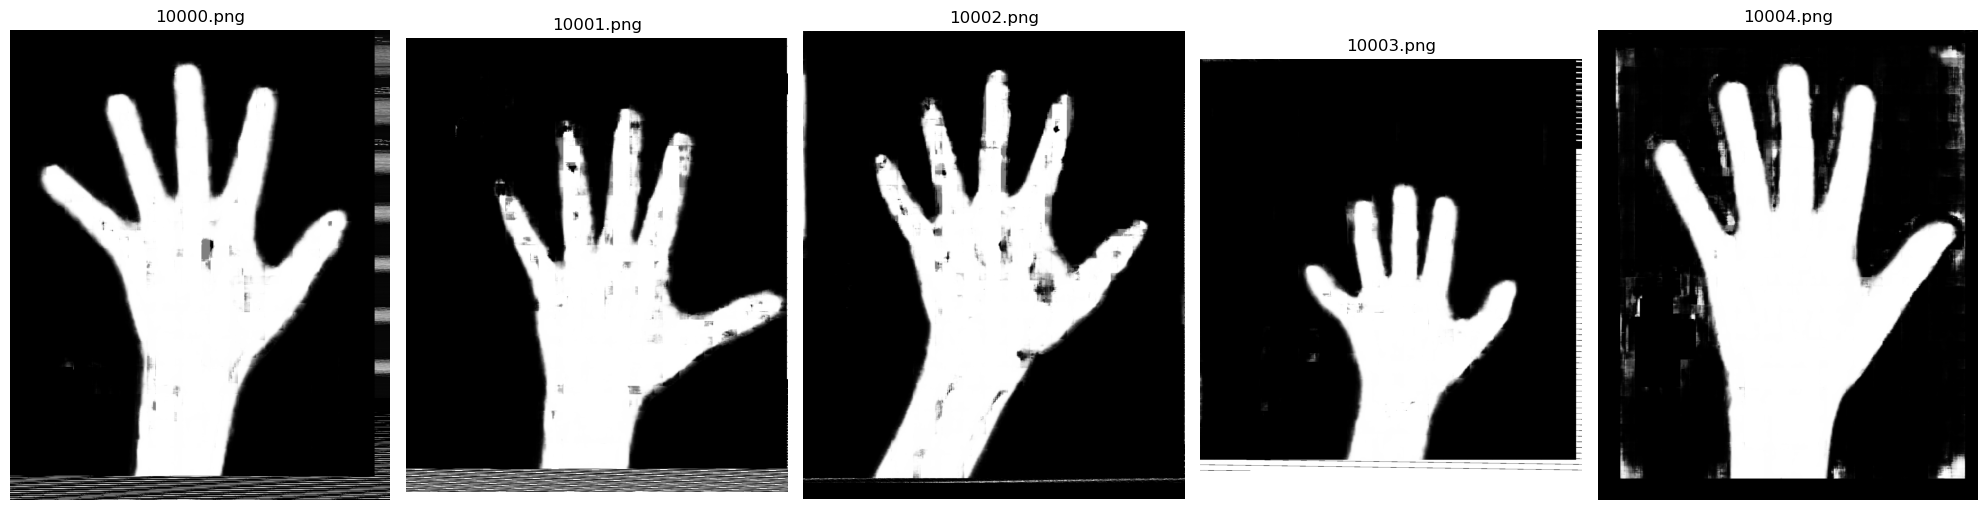

In [20]:
import os
from PIL import Image
import matplotlib.pyplot as plt

# Function to display up to 5 grayscale images from a folder side by side
def display_grayscale_images_from_folder(folder_path, max_images=5):
    # Get a list of all files in the folder
    files = os.listdir(folder_path)
    
    # Filter out image files (assuming they have typical image extensions)
    image_extensions = ['.png', '.jpg', '.jpeg', '.gif', '.bmp']
    image_files = [f for f in files if os.path.splitext(f)[1].lower() in image_extensions]
    
    # Limit the number of images to display
    image_files = image_files[:max_images]
    
    # Create a figure to display images
    num_images = len(image_files)
    plt.figure(figsize=(min(num_images * 4, 20), 5))  # Adjust figure size based on the number of images
    
    # Loop through image files and display each one
    for i, image_file in enumerate(image_files):
        image_path = os.path.join(folder_path, image_file)
        if os.path.exists(image_path):
            image = Image.open(image_path).convert('L')  # Convert to grayscale
            
            plt.subplot(1, num_images, i + 1)  # Create a subplot for each image
            plt.imshow(image, cmap='gray')  # Display in grayscale
            plt.axis('off')  # Hide axis
            plt.title(image_file)  # Set the title of the subplot
        else:
            print(f"Image {image_file} not found in the folder.")
    
    # Adjust layout and show the images
    plt.tight_layout()
    plt.show()

# Replace 'your_folder_path_here' with the path to your folder
folder_path = 'finally binary images'

display_grayscale_images_from_folder(folder_path)


Apply contours to images

In [21]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Function to apply contours to an image and display the result
def apply_contours_to_image(image_path):
    # Read the image
    image = cv2.imread(image_path)
    if image is None:
        print(f"Error: Image at path '{image_path}' could not be loaded.")
        return

    # Convert the image to grayscale
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Apply a binary threshold to the grayscale image
    _, binary_image = cv2.threshold(gray_image, 127, 255, cv2.THRESH_BINARY)
    
    # Find contours in the binary image
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Draw the contours on the original image
    contour_image = image.copy()
    cv2.drawContours(contour_image, contours, -1, (0, 255, 0), 2)  # Green contours with thickness 2

    # Convert the image from BGR to RGB (for displaying with matplotlib)
    contour_image_rgb = cv2.cvtColor(contour_image, cv2.COLOR_BGR2RGB)
    
    # Display the image with contours
    plt.imshow(contour_image_rgb)
    plt.axis('off')  # Hide the axis
    plt.show()


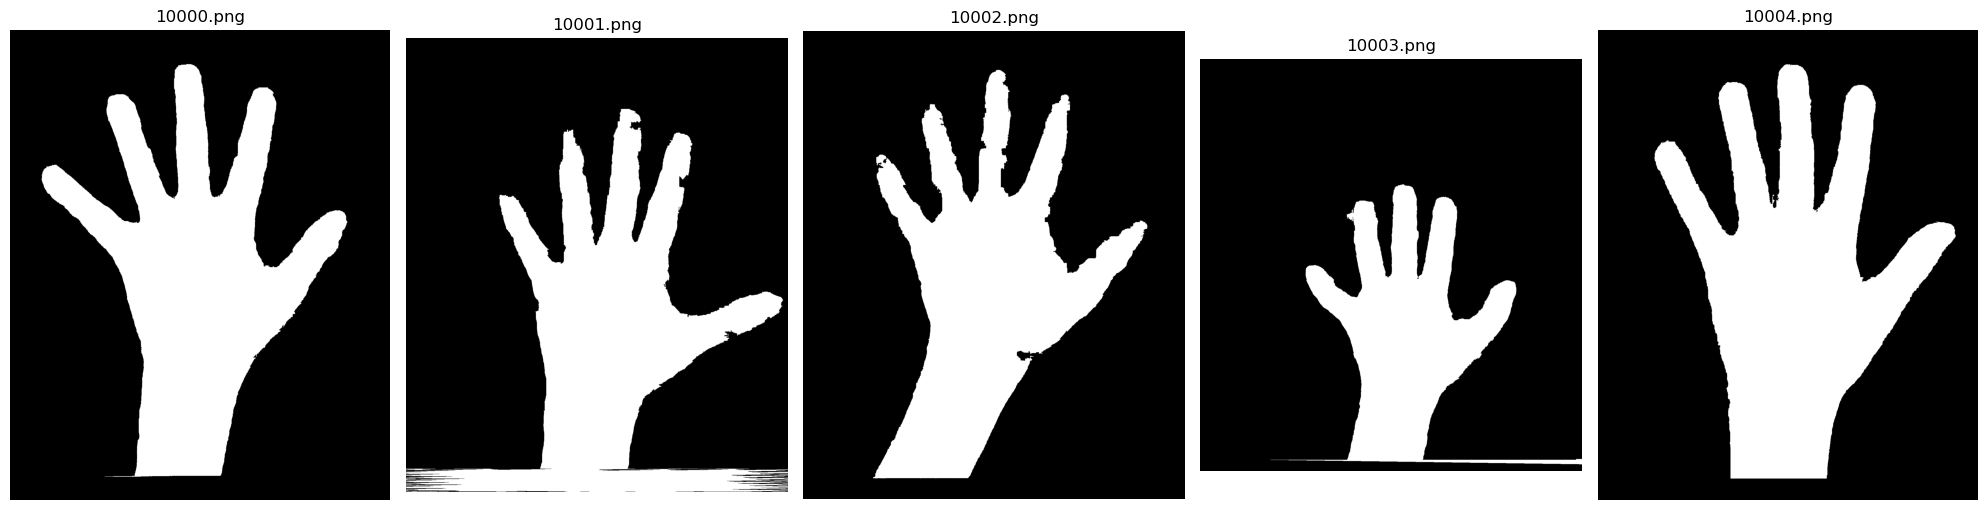

In [23]:
import os
from PIL import Image
import matplotlib.pyplot as plt

# Function to display specific images from a folder in grayscale side by side
def display_specific_images_from_folder(folder_path, image_names):
    # Create a figure to display images
    num_images = len(image_names)
    plt.figure(figsize=(min(num_images * 4, 20), 5))  # Adjust figure size based on the number of images
    
    # Loop through specified image names and display each one
    for i, image_name in enumerate(image_names):
        image_path = os.path.join(folder_path, image_name)
        if os.path.exists(image_path):
            image = Image.open(image_path).convert('L')  # Convert to grayscale
            
            plt.subplot(1, num_images, i + 1)  # Create a subplot for each image
            plt.imshow(image, cmap='gray')  # Display in grayscale
            plt.axis('off')  # Hide axis
            plt.title(image_name)  # Set the title of the subplot
        else:
            print(f"Image {image_name} not found in the folder.")
    
    # Adjust layout and show the images
    plt.tight_layout()
    plt.show()

# Replace 'your_folder_path_here' with the path to your folder
folder_path = 'finally binary images contours'

# List of specific image filenames
image_names = ['10000.png', '10001.png', '10002.png', '10003.png', '10004.png']

display_specific_images_from_folder(folder_path, image_names)


Apply Dilation To Images

In [24]:
import cv2
import numpy as np
import os

# Function to apply dilation to images in a folder
def apply_dilation_to_images(folder_path, output_folder, kernel_size=(11, 11), iterations=1):
    # Create output folder if it doesn't exist
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    # Get a list of all files in the folder
    files = os.listdir(folder_path)

    # Filter out image files (assuming they have typical image extensions)
    image_extensions = ['.png', '.jpg', '.jpeg', '.gif', '.bmp']
    image_files = [f for f in files if os.path.splitext(f)[1].lower() in image_extensions]

    for image_name in image_files:
        image_path = os.path.join(folder_path, image_name)
        image = cv2.imread(image_path)
        
        if image is None:
            print(f"Error: Image at path '{image_path}' could not be loaded.")
            continue

        # Convert image to grayscale
        gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        
        # Apply binary threshold to get a binary image
        _, binary_image = cv2.threshold(gray_image, 127, 255, cv2.THRESH_BINARY)

        # Define the structuring element for dilation
        kernel = np.ones(kernel_size, np.uint8)
        
        # Apply dilation
        dilated_image = cv2.dilate(binary_image, kernel, iterations=iterations)

        # Save the dilated image
        output_path = os.path.join(output_folder, image_name)
        cv2.imwrite(output_path, dilated_image)

        print(f"Dilated image saved at: {output_path}")

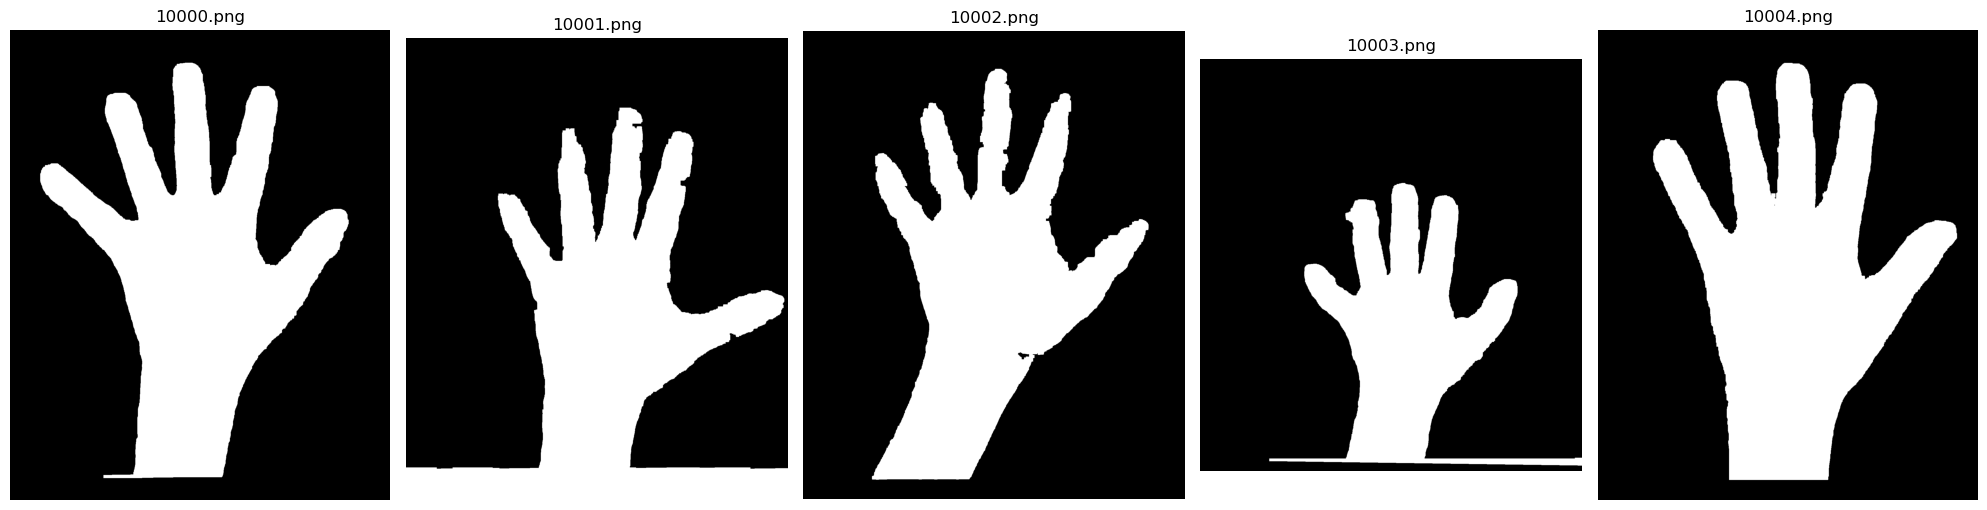

In [25]:
import os
from PIL import Image
import matplotlib.pyplot as plt

# Function to display specific images from a folder in grayscale side by side
def display_specific_images_from_folder(folder_path, image_names):
    # Create a figure to display images
    num_images = len(image_names)
    plt.figure(figsize=(min(num_images * 4, 20), 5))  # Adjust figure size based on the number of images
    
    # Loop through specified image names and display each one
    for i, image_name in enumerate(image_names):
        image_path = os.path.join(folder_path, image_name)
        if os.path.exists(image_path):
            image = Image.open(image_path).convert('L')  # Convert to grayscale
            
            plt.subplot(1, num_images, i + 1)  # Create a subplot for each image
            plt.imshow(image, cmap='gray')  # Display in grayscale
            plt.axis('off')  # Hide axis
            plt.title(image_name)  # Set the title of the subplot
        else:
            print(f"Image {image_name} not found in the folder.")
    
    # Adjust layout and show the images
    plt.tight_layout()
    plt.show()

# Replace 'your_folder_path_here' with the path to your folder
folder_path = 'finally binary images dilated'

# List of specific image filenames
image_names = ['10000.png', '10001.png', '10002.png', '10003.png', '10004.png']

display_specific_images_from_folder(folder_path, image_names)


Apply Overlay To Images

In [26]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt

# Function to overlay binary masks on images and save or display the results
def overlay_masks_on_images(images_folder, masks_folder, output_folder, alpha=0.5):
    # Create the output folder if it doesn't exist
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    
    # List all image files in the images folder
    image_files = [f for f in os.listdir(images_folder) if os.path.splitext(f)[1].lower() in ['.png', '.jpg', '.jpeg']]
    
    for image_name in image_files:
        image_path = os.path.join(images_folder, image_name)
        mask_path = os.path.join(masks_folder, image_name)
        output_path = os.path.join(output_folder, image_name)
        
        # Load the image and mask
        image = cv2.imread(image_path)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)  # Load mask in grayscale

        if image is None:
            print(f"Error: Image at path '{image_path}' could not be loaded.")
            continue
        if mask is None:
            print(f"Error: Mask at path '{mask_path}' could not be loaded.")
            continue

        # Ensure the mask is binary
        _, binary_mask = cv2.threshold(mask, 127, 255, cv2.THRESH_BINARY)
        
        # Convert the binary mask to a 3-channel image
        mask_colored = cv2.cvtColor(binary_mask, cv2.COLOR_GRAY2BGR)
        
        # Create a blended image using the mask
        blended_image = cv2.addWeighted(image, 1 - alpha, mask_colored, alpha, 0)

        # Save the result
        cv2.imwrite(output_path, blended_image)

        print(f"Overlay result saved at: {output_path}")

    print("All images processed.")

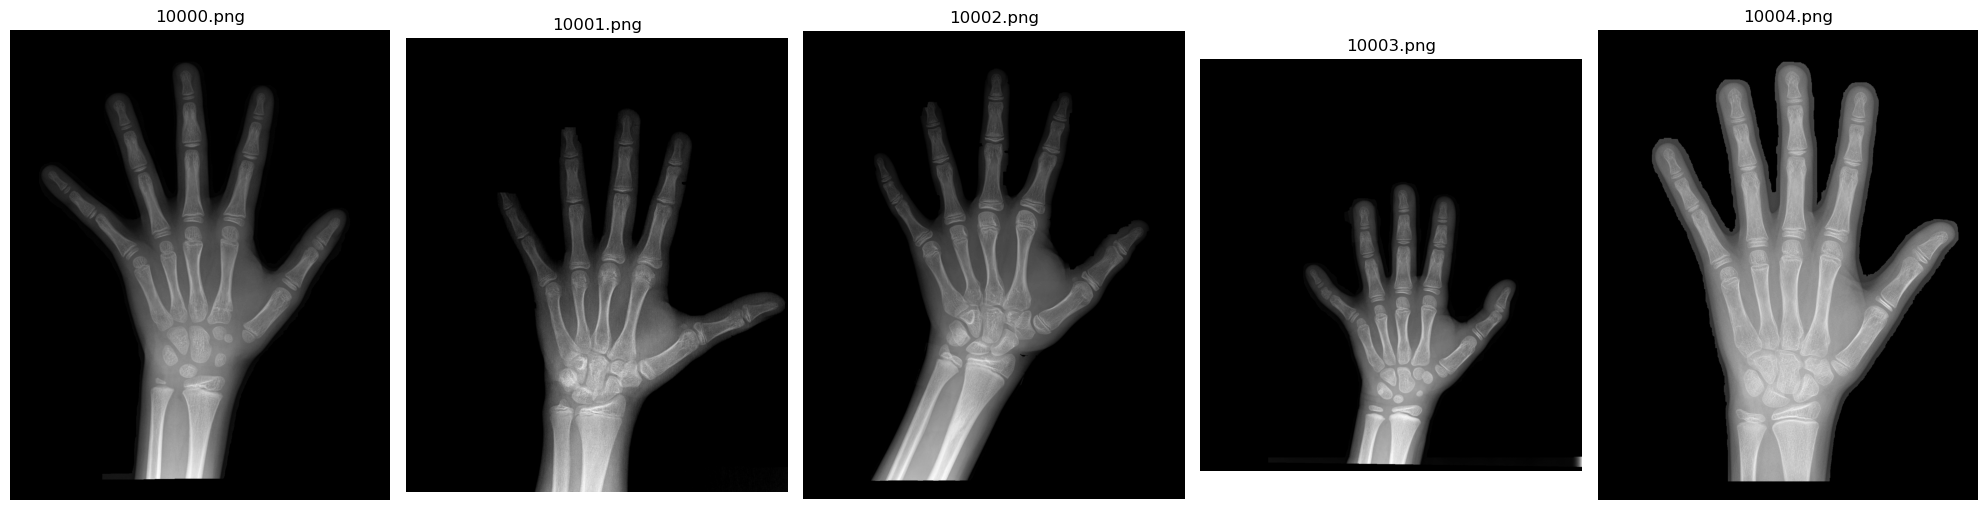

In [27]:
import os
from PIL import Image
import matplotlib.pyplot as plt

# Function to display specific images from a folder in grayscale side by side
def display_specific_images_from_folder(folder_path, image_names):
    # Create a figure to display images
    num_images = len(image_names)
    plt.figure(figsize=(min(num_images * 4, 20), 5))  # Adjust figure size based on the number of images
    
    # Loop through specified image names and display each one
    for i, image_name in enumerate(image_names):
        image_path = os.path.join(folder_path, image_name)
        if os.path.exists(image_path):
            image = Image.open(image_path).convert('L')  # Convert to grayscale
            
            plt.subplot(1, num_images, i + 1)  # Create a subplot for each image
            plt.imshow(image, cmap='gray')  # Display in grayscale
            plt.axis('off')  # Hide axis
            plt.title(image_name)  # Set the title of the subplot
        else:
            print(f"Image {image_name} not found in the folder.")
    
    # Adjust layout and show the images
    plt.tight_layout()
    plt.show()

# Replace 'your_folder_path_here' with the path to your folder
folder_path = 'finally overlay images'

# List of specific image filenames
image_names = ['10000.png', '10001.png', '10002.png', '10003.png', '10004.png']

display_specific_images_from_folder(folder_path, image_names)


Now We Can Start the project ...

In [28]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt # showing and rendering figures
# io related
from skimage.io import imread
import os
from glob import glob
# not needed in Kaggle, but required in Jupyter
%matplotlib inline

In [29]:
import os
import pandas as pd

# Directories for images and CSV file
image_dir = "finally overlay images jpg"
csv_file_path = 'boneage-training-dataset - Copy.csv'

# Load the CSV file
age_df = pd.read_csv(csv_file_path)

# Map the 'id' column to the file paths of the corresponding images in the directory
age_df['path'] = age_df['id'].map(lambda x: os.path.join(image_dir, '{}.jpg'.format(x)))

# Check if the images exist in the directory
age_df['exists'] = age_df['path'].map(os.path.exists)
print(age_df['exists'].sum(), 'images found of', age_df.shape[0], 'total')

# Map the 'male' column to a readable 'gender' format
age_df['gender'] = age_df['male'].map(lambda x: 'male' if x else 'female')

# Calculate the mean and standard deviation for bone age
boneage_mean = age_df['boneage'].mean()
boneage_div = 2 * age_df['boneage'].std()

# Disable normalization if desired
boneage_mean = 0
boneage_div = 1.0

# Create a 'boneage_zscore' column for normalized bone age values
age_df['boneage_zscore'] = age_df['boneage'].map(lambda x: (x - boneage_mean) / boneage_div)

# Drop any rows with missing values
age_df.dropna(inplace=True)

# Display a sample of the data
age_df.sample(3)


10121 images found of 10121 total


,id,boneage,male,path,exists,gender,boneage_zscore
3382,7844,138,False,finally overlay images jpg\7844.jpg,True,female,138.0
9882,15334,150,True,finally overlay images jpg\15334.jpg,True,male,150.0
10078,15560,69,False,finally overlay images jpg\15560.jpg,True,female,69.0


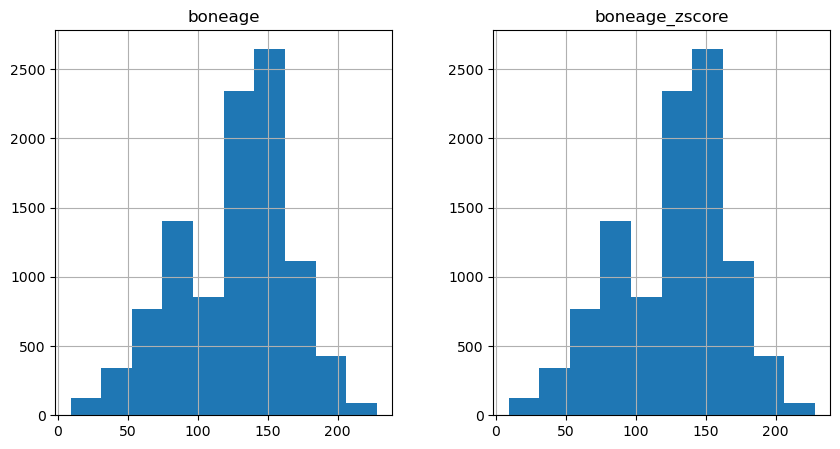

In [30]:
age_df[['boneage', 'male', 'boneage_zscore']].hist(figsize = (10, 5))
age_df['boneage_category'] = pd.cut(age_df['boneage'], 10)

Create model for ages between 84 and 168

In [53]:
# Define the range
lower_bound = 84
upper_bound = 168

# Extract rows where 'boneage' is between lower_bound and upper_bound
filtered_df = age_df[(age_df['boneage'] > lower_bound) & (age_df['boneage'] < upper_bound)]
age_df = filtered_df
#print(filtered_df)

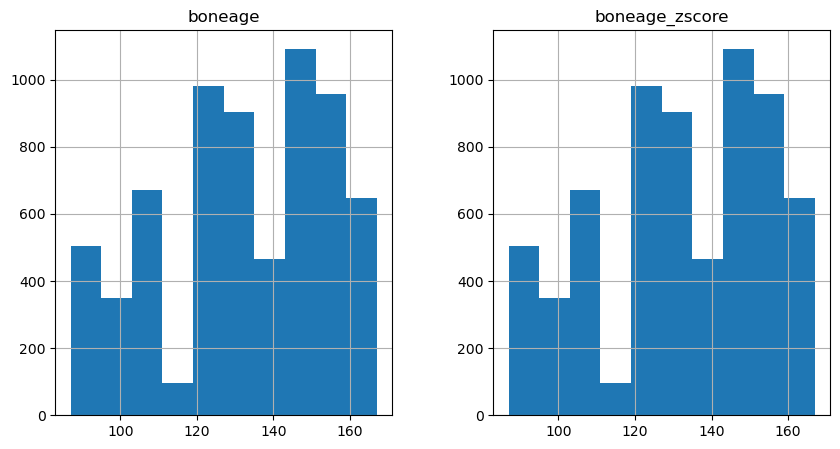

In [54]:
age_df[['boneage', 'male', 'boneage_zscore']].hist(figsize = (10, 5))
age_df['boneage_category'] = pd.cut(age_df['boneage'], 10)

In [55]:
from sklearn.model_selection import train_test_split
raw_train_df, valid_df = train_test_split(age_df, 
                                   test_size = 0.25, 
                                   random_state = 2018,
                                   stratify = age_df['boneage_category'])
print('train', raw_train_df.shape[0], 'validation', valid_df.shape[0])

train 4995 validation 1665


New Data Size: 8000 Old Size: 4995


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_21952\337190614.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  train_df = raw_train_df.groupby(['boneage_category', 'male']).apply(lambda x: x.sample(400, replace = True)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_21952\337190614.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  train_df = raw_train_df.groupby(['boneage_category', 'male']).apply(lambda x: x.sample(400, replace = True)


array([[<Axes: title={'center': 'boneage'}>]], dtype=object)

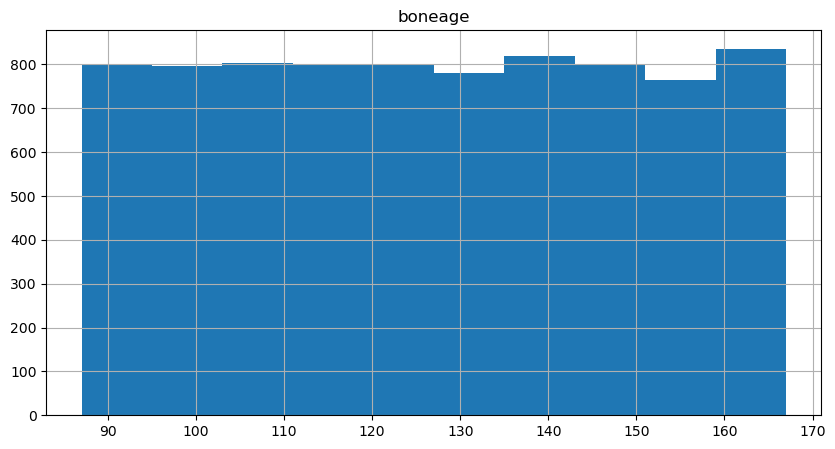

In [56]:
train_df = raw_train_df.groupby(['boneage_category', 'male']).apply(lambda x: x.sample(400, replace = True)
                                                      ).reset_index(drop = True)
print('New Data Size:', train_df.shape[0], 'Old Size:', raw_train_df.shape[0])
train_df[['boneage', 'male']].hist(figsize = (10, 5))

In [36]:
#!pip install pandas
#!pip install scikit-learn
#!pip install opencv-python-headless
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import callbacks
from tensorflow.keras import layers, models, Input, Model
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import cv2

def custom_resize(image, target_size):
    return cv2.resize(image, target_size, interpolation=cv2.INTER_AREA)

def load_and_preprocess_data(csv_path, image_folder, target_size=(384, 384), is_training=True):
    df = raw_train_df
    
    images = []
    boneages = []
    genders = []

    for _, row in df.iterrows():
        img_path = os.path.join(image_folder, f"{row['id']}.png")
        if os.path.exists(img_path):
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            img = custom_resize(img, target_size)
            #img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img_array = img.astype(np.float32) / 255.0
            images.append(img_array)
            
            if is_training:
                boneages.append(row['boneage'])
                genders.append(1 if row['male'] == True else 0)
    images = np.array(images)
    images = np.expand_dims(images, axis=-1)  # Add channel dimension
    
    if is_training:
        boneages = np.array(boneages)
        genders = np.array(genders)
        return images, boneages, genders
    else:
        return images, df['id'].values

def create_vgg_style_cnn(image_input_shape, gender_input_shape):
    # Image input
    image_input = Input(shape=image_input_shape)

    conv_filters = [32, 64, 128, 128, 256, 384]
    
    x = image_input
    for filters in conv_filters:
        x = layers.Conv2D(filters, (3, 3), activation='relu', padding='same')(x)
        x = layers.BatchNormalization()(x)
        x = layers.MaxPooling2D((2, 2))(x)
    
    x = layers.Flatten()(x)

    # Gender input
    gender_input = Input(shape=gender_input_shape)
    
    # Concatenate image features with gender input
    x = layers.concatenate([x, gender_input])

    # Fully connected layers
    for _ in range(2):
        x = layers.Dropout(0.2)(x)
        x = layers.Dense(2048, activation='relu')(x)
    
    # Output layer
    output = layers.Dense(1)(x)  # Single output for regression
    
    # Create the model
    model = Model(inputs=[image_input, gender_input], outputs=output)
    
    return model
"""
# Load and preprocess training data
train_images, train_boneages, train_genders = load_and_preprocess_data("/kaggle/input/train-and-test2/boneage-training-dataset - Copy (2).csv", "/kaggle/input/finally-overlay-images/finally overlay images")

# Split training data into training and validation sets
X_train, X_val, y_train, y_val, gender_train, gender_val = train_test_split(
    train_images, train_boneages, train_genders, test_size=0.2, random_state=42)

# Scale bone ages to [-1, 1] range
#scaler = StandardScaler()
#y_train_scaled = scaler.fit_transform(y_train.reshape(-1, 1)).flatten()
#y_val_scaled = scaler.transform(y_val.reshape(-1, 1)).flatten()

# Create and compile the model
image_input_shape = (384, 384, 1)
gender_input_shape = (1,)
model = create_vgg_style_cnn(image_input_shape, gender_input_shape)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
              loss='mean_absolute_error',
              metrics=['mean_squared_error', 'mean_absolute_error'])

# Define data augmentation
data_augmentation = tf.keras.Sequential([
    #tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomTranslation(0.1,0.1),
    tf.keras.layers.RandomContrast(0.1)
    # Consider removing or optimizing other augmentations
])

callbacks = [
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10),
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True),
    tf.keras.callbacks.ModelCheckpoint(
        'model_epoch_{epoch:04d}.keras',  # File pattern to save model checkpoints
        save_freq=40 * len(X_train) // 32,  # Save the model every 40 epochs
        save_best_only=False  # Set to False to save every 40th epoch, regardless of performance
    )
]
# Train the model
history = model.fit(
    [data_augmentation(X_train), gender_train], y_train,
    validation_data=([X_val, gender_val], y_val),
    epochs=200,
    batch_size=32,
    callbacks=[
        tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10),
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True)
    ]
)

# Load and preprocess test data
test_images, test_ids = load_and_preprocess_data("/kaggle/input/train-and-test2/boneage-test-dataset - Copy.csv", "/kaggle/input/finally-overlay-images/finally overlay images", is_training=False)

# You need to include the gender information during inference as well, this is just an example
# Assuming you have a default gender input (e.g., male = 1)
test_genders = np.ones((test_images.shape[0], 1))  # Replace with actual gender information if available

# Make predictions on test data
test_predictions = model.predict([test_images, test_genders])

# Inverse transform the predictions to get original scale
#test_predictions_original = scaler.inverse_transform(test_predictions)

# Create a DataFrame with test results
test_results = pd.DataFrame({
    'id': test_ids,
    'predicted_boneage': test_predictions_original.flatten()
})

# Save test results to CSV
test_results.to_csv('/kaggle/working/finally.csv', index=False)

print("Training completed and test predictions saved to 'test_predictions.csv'")
"""

'\n# Load and preprocess training data\ntrain_images, train_boneages, train_genders = load_and_preprocess_data("/kaggle/input/train-and-test2/boneage-training-dataset - Copy (2).csv", "/kaggle/input/finally-overlay-images/finally overlay images")\n\n# Split training data into training and validation sets\nX_train, X_val, y_train, y_val, gender_train, gender_val = train_test_split(\n    train_images, train_boneages, train_genders, test_size=0.2, random_state=42)\n\n# Scale bone ages to [-1, 1] range\n#scaler = StandardScaler()\n#y_train_scaled = scaler.fit_transform(y_train.reshape(-1, 1)).flatten()\n#y_val_scaled = scaler.transform(y_val.reshape(-1, 1)).flatten()\n\n# Create and compile the model\nimage_input_shape = (384, 384, 1)\ngender_input_shape = (1,)\nmodel = create_vgg_style_cnn(image_input_shape, gender_input_shape)\nmodel.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),\n              loss=\'mean_absolute_error\',\n              metrics=[\'mean_squared_error\',

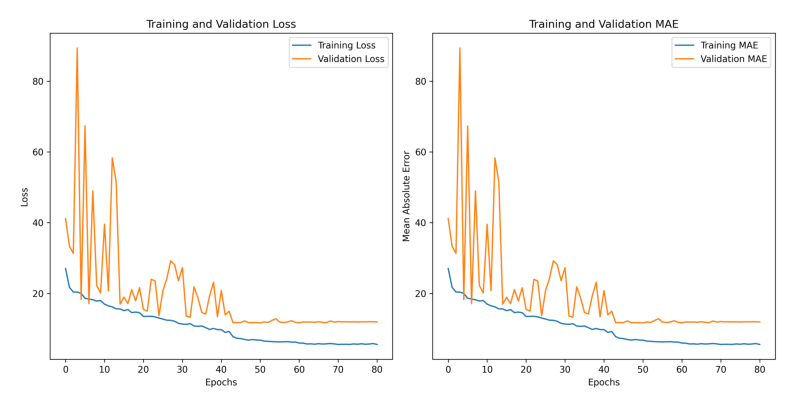

In [38]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Function to display an image
def show_image(image_path):
    # Read the image
    img = mpimg.imread(image_path)
    
    # Create a plot
    plt.figure(figsize=(10, 10))  # Adjust the figure size as needed
    plt.imshow(img)
    plt.axis('off')  # Hide axes
    plt.show()

# Replace with the path to your image
image_path = r"C:\Users\LENOVO\Downloads\training_history(2).png"
show_image(image_path)


Apply model for all ages

In [39]:
import os
import pandas as pd

# Directories for images and CSV file
image_dir = "finally overlay images jpg"
csv_file_path = 'boneage-training-dataset - Copy.csv'

# Load the CSV file
age_df = pd.read_csv(csv_file_path)

# Map the 'id' column to the file paths of the corresponding images in the directory
age_df['path'] = age_df['id'].map(lambda x: os.path.join(image_dir, '{}.jpg'.format(x)))

# Check if the images exist in the directory
age_df['exists'] = age_df['path'].map(os.path.exists)
print(age_df['exists'].sum(), 'images found of', age_df.shape[0], 'total')

# Map the 'male' column to a readable 'gender' format
age_df['gender'] = age_df['male'].map(lambda x: 'male' if x else 'female')

# Calculate the mean and standard deviation for bone age
boneage_mean = age_df['boneage'].mean()
boneage_div = 2 * age_df['boneage'].std()

# Disable normalization if desired
boneage_mean = 0
boneage_div = 1.0

# Create a 'boneage_zscore' column for normalized bone age values
age_df['boneage_zscore'] = age_df['boneage'].map(lambda x: (x - boneage_mean) / boneage_div)

# Drop any rows with missing values
age_df.dropna(inplace=True)

# Display a sample of the data
age_df.sample(3)


10121 images found of 10121 total


,id,boneage,male,path,exists,gender,boneage_zscore
6320,11220,106,False,finally overlay images jpg\11220.jpg,True,female,106.0
8173,13361,150,True,finally overlay images jpg\13361.jpg,True,male,150.0
5087,9793,132,True,finally overlay images jpg\9793.jpg,True,male,132.0


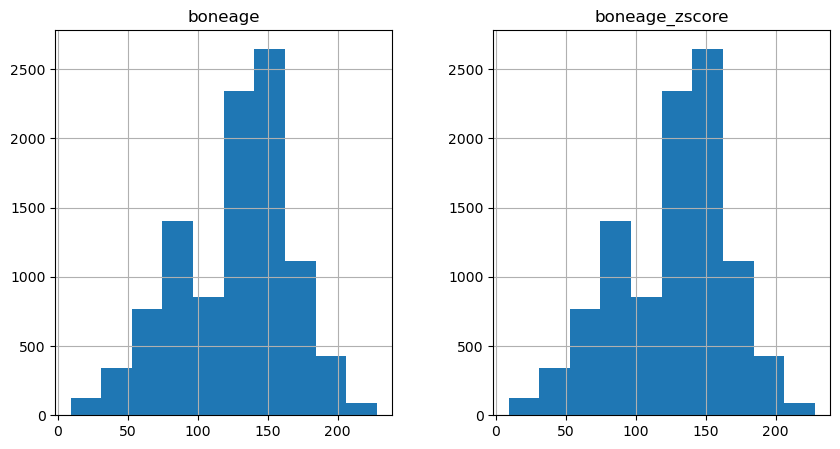

In [41]:
age_df[['boneage', 'male', 'boneage_zscore']].hist(figsize = (10, 5))
age_df['boneage_category'] = pd.cut(age_df['boneage'], 10)

In [42]:
from sklearn.model_selection import train_test_split
raw_train_df, valid_df = train_test_split(age_df, 
                                   test_size = 0.25, 
                                   random_state = 2018,
                                   stratify = age_df['boneage_category'])
print('train', raw_train_df.shape[0], 'validation', valid_df.shape[0])

train 7590 validation 2531


New Data Size: 10000 Old Size: 7590


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_21952\876977220.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  train_df = raw_train_df.groupby(['boneage_category', 'male']).apply(lambda x: x.sample(500, replace = True)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_21952\876977220.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  train_df = raw_train_df.groupby(['boneage_category', 'male']).apply(lambda x: x.sample(500, replace = True)


array([[<Axes: title={'center': 'boneage'}>]], dtype=object)

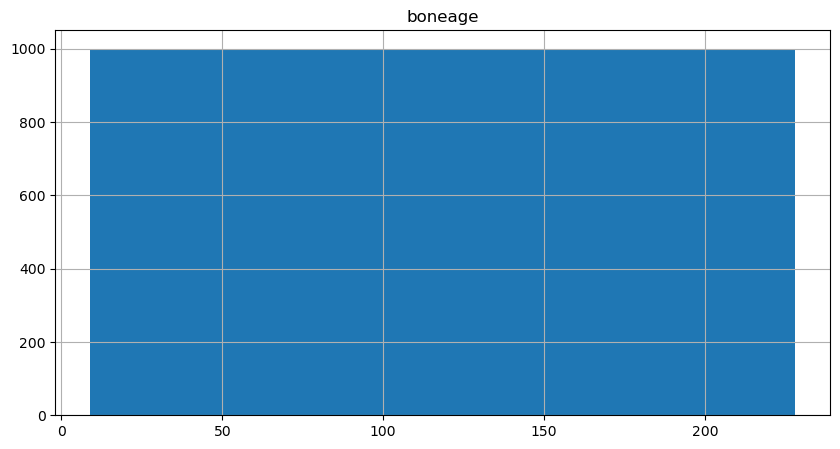

In [43]:
train_df = raw_train_df.groupby(['boneage_category', 'male']).apply(lambda x: x.sample(500, replace = True)
                                                      ).reset_index(drop = True)
print('New Data Size:', train_df.shape[0], 'Old Size:', raw_train_df.shape[0])
train_df[['boneage', 'male']].hist(figsize = (10, 5))

In [48]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import preprocess_input
IMG_SIZE = (384, 384) # slightly smaller than vgg16 normally expects
core_idg = ImageDataGenerator(samplewise_center=False, 
                              samplewise_std_normalization=False, 
                              horizontal_flip = True, 
                              vertical_flip = False, 
                              height_shift_range = 0.15,
                              width_shift_range = 0.15, 
                              rotation_range = 5, 
                              shear_range = 0.01,
                              fill_mode = 'nearest',
                              zoom_range=0.25,
                             preprocessing_function = preprocess_input)

In [50]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
def check_missing_files(df, path_col):
    missing_files = df[~df[path_col].apply(os.path.exists)]
    print(f"Number of missing files: {len(missing_files)}")
    if len(missing_files) > 0:
        print("First few missing files:")
        print(missing_files[path_col].head())
    return missing_files
check_missing_files(train_df, 'path')
check_missing_files(valid_df, 'path')
import numpy as np
from sklearn.preprocessing import StandardScaler

# Convert Pandas Series to NumPy array and reshape
scaler = StandardScaler()

# Convert to NumPy array and reshape
y_train = train_df["boneage_zscore"].to_numpy().reshape(-1, 1)
y_val = valid_df["boneage_zscore"].to_numpy().reshape(-1, 1)

# Fit the scaler on the training data and transform
y_train_scaled = scaler.fit_transform(y_train).flatten()

# Transform the validation data
y_val_scaled = scaler.transform(y_val).flatten()

# Add scaled labels to DataFrames
train_df['scaled_boneage_zscore'] = y_train_scaled
valid_df['scaled_boneage_zscore'] = y_val_scaled
train_gen = core_idg.flow_from_dataframe(
    dataframe=train_df,
    directory=None,  # Full path provided in the dataframe
    x_col='path',
    y_col='scaled_boneage_zscore',
    target_size=IMG_SIZE,
    color_mode='rgb',
    class_mode="raw",  # or 'raw' if you are using numeric labels
    batch_size=32,
    shuffle=True
)

valid_gen = core_idg.flow_from_dataframe(
    dataframe=valid_df,
    directory=None,  # Full path provided in the dataframe
    x_col='path',
    y_col="scaled_boneage_zscore",
    target_size=IMG_SIZE,
    color_mode='rgb',
    class_mode="raw",  # or 'raw' if you are using numeric labels
    batch_size=256,  # Larger batch size for evaluation
    shuffle=False
)

test_X = []
test_Y = []

for _ in range(len(valid_df) // 256 + 1):
    batch_X, batch_Y = next(valid_gen)
    test_X.extend(batch_X)
    test_Y.extend(batch_Y)

Number of missing files: 0
Number of missing files: 0
Found 10000 validated image filenames.
Found 2531 validated image filenames.


Apply the model to ages less than 84 and greater than 168

In [51]:
import numpy as np

# Convert test_X and test_Y to numpy arrays if they aren't already
test_X = np.array(test_X)
test_Y = np.array(test_Y)
test_Y = test_Y.flatten()
test_Y = test_Y.reshape(-1,1)
test_Y = scaler.inverse_transform(test_Y)
test_Y = test_Y.flatten()
# Create a boolean mask for values of test_Y between 84 and 168
selected_indices = np.where((test_Y < 84) | (test_Y > 168))[0]

# Extract the test_Y values using these indices
extracted_Y = test_Y[selected_indices]

# Extract the corresponding test_X values using the same indices
extracted_X = np.array(test_X)[selected_indices]

print(f"Shape of extracted X: {extracted_X.shape}")
print(f"Shape of extracted Y: {extracted_Y.shape}")
print(f"Number of samples extracted: {len(selected_indices)}")

# Verify the range of extracted_Y
"""
print(f"Min value in extracted Y: {np.min(extracted_Y)}")
print(f"Max value in extracted Y: {np.max(extracted_Y)}")

# Print a few indices to verify
print(f"First few selected indices: {selected_indices[:5]}")
"""

Shape of extracted X: (630, 384, 384, 3)
Shape of extracted Y: (630,)
Number of samples extracted: 630


'\nprint(f"Min value in extracted Y: {np.min(extracted_Y)}")\nprint(f"Max value in extracted Y: {np.max(extracted_Y)}")\n\n# Print a few indices to verify\nprint(f"First few selected indices: {selected_indices[:5]}")\n'

In [57]:
model = tf.keras.models.load_model(r"C:\Users\LENOVO\Downloads\model_epoch_56 (1) (1).keras")

In [58]:
predictions = model.predict(extracted_X)

20/20 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step


In [59]:
predictions = scaler.inverse_transform(predictions)

Apply model 1 for ages between 84 and 168

In [61]:
#!pip install pandas
#!pip install scikit-learn
#!pip install opencv-python-headless
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import callbacks
from tensorflow.keras import layers, models, Input, Model
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import cv2

def custom_resize(image, target_size):
    return cv2.resize(image, target_size, interpolation=cv2.INTER_AREA)

def load_and_preprocess_data(csv_path, image_folder, target_size=(384, 384), is_training=True):
    df = valid_df
    
    images = []
    boneages = []
    genders = []

    for _, row in df.iterrows():
        img_path = os.path.join(image_folder, f"{row['id']}.jpg")
        if os.path.exists(img_path):
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            img = custom_resize(img, target_size)
            #img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img_array = img.astype(np.float32) / 255.0
            images.append(img_array)
            
            if is_training:
                boneages.append(row['boneage'])
                genders.append(1 if row['male'] == True else 0)
    images = np.array(images)
    images = np.expand_dims(images, axis=-1)  # Add channel dimension
    
    if is_training:
        boneages = np.array(boneages)
        genders = np.array(genders)
        return images, boneages, genders
    else:
        return images, df['id'].values

def create_vgg_style_cnn(image_input_shape, gender_input_shape):
    # Image input
    image_input = Input(shape=image_input_shape)

    conv_filters = [32, 64, 128, 128, 256, 384]
    
    x = image_input
    for filters in conv_filters:
        x = layers.Conv2D(filters, (3, 3), activation='relu', padding='same')(x)
        x = layers.BatchNormalization()(x)
        x = layers.MaxPooling2D((2, 2))(x)
    
    x = layers.Flatten()(x)

    # Gender input
    gender_input = Input(shape=gender_input_shape)
    
    # Concatenate image features with gender input
    x = layers.concatenate([x, gender_input])

    # Fully connected layers
    for _ in range(2):
        x = layers.Dropout(0.2)(x)
        x = layers.Dense(2048, activation='relu')(x)
    
    # Output layer
    output = layers.Dense(1)(x)  # Single output for regression
    
    # Create the model
    model = Model(inputs=[image_input, gender_input], outputs=output)
    
    return model


# Load and preprocess test data
test_images, test_ids = load_and_preprocess_data(r"", "finally overlay images jpg", is_training=False)

# You need to include the gender information during inference as well, this is just an example
# Assuming you have a default gender input (e.g., male = 1)
test_genders = valid_df["male"].astype(int).values  # Replace with actual gender information if available
test_genders = test_genders.flatten()
import tensorflow as tf
from tensorflow.keras.models import load_model
model2 = load_model(r"C:\Users\LENOVO\Downloads\my_model(2)_84_168.keras")
# Make predictions on test data
test_predictions = model2.predict([test_images,test_genders])

# Inverse transform the predictions to get original scale
#test_predictions_original = scaler.inverse_transform(test_predictions)

# Create a DataFrame with test results
test_results = pd.DataFrame({
    'id': test_ids,
    'predicted_boneage': test_predictions.flatten()
})

53/53 ━━━━━━━━━━━━━━━━━━━━ 59s 1s/step


In [62]:
test_predictions = test_predictions.flatten()
predictions_84_168 = test_predictions
extracted_Y_84_168 = valid_df["boneage"].values.flatten()
predictions = predictions.flatten()

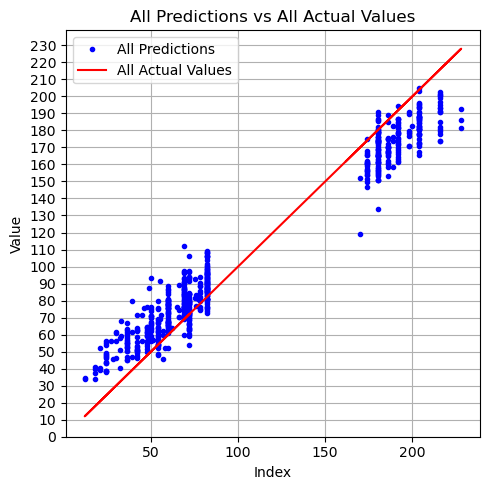

In [440]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming your arrays are already defined
# predictions_84_168, extracted_Y_84_168, predictions, extracted_Y

# Combine the prediction arrays
all_predictions = np.concatenate([predictions, predictions_84_168])

# Combine the actual value arrays
all_actual = np.concatenate([extracted_Y, extracted_Y_84_168])

# Create indices for the x-axis
indices = np.arange(len(all_predictions))

# Create a figure and axis object
fig, ax = plt.subplots(figsize=(5, 5))

# Plot all predictions as scatter points
ax.plot(extracted_Y, predictions, 'b.', label='All Predictions')

# Plot all actual values as a line
ax.plot(all_actual, all_actual, color='red', label='All Actual Values')

# Set title and labels
ax.set_title('All Predictions vs All Actual Values')
ax.set_xlabel('Index')
ax.set_ylabel('Value')

# Add grid
ax.grid(True)

# Set y-axis ticks to be in multiples of 10
y_ticks = np.arange(0, max(np.max(all_predictions), np.max(all_actual)) + 10, 10)
ax.set_yticks(y_ticks)

# Add legend
ax.legend()

# Adjust the layout and display the plot
plt.tight_layout()
plt.show()


In [448]:
import numpy as np

def adjust_predictions(predictions):
    # Convert predictions to a numpy array if it isn't already
    predictions = np.array(predictions)
    
    # Create a copy of predictions to adjust
    adjusted_predictions = np.copy(predictions)
    
    # Apply adjustments based on the specified ranges
    adjusted_predictions[predictions < 40] -= 20
    adjusted_predictions[(predictions >= 40) & (predictions < 50)] -= 15
    adjusted_predictions[(predictions >= 50) & (predictions < 60)] -= 13
    adjusted_predictions[(predictions >= 60) & (predictions < 70)] -= 10
    adjusted_predictions[(predictions >= 70) & (predictions < 80)] -= 10
    adjusted_predictions[(predictions >= 80) & (predictions < 90)] -= 10
    adjusted_predictions[(predictions >= 90) & (predictions < 100)] -= 10
    adjusted_predictions[(predictions >= 100) & (predictions < 110)] -= 10
    adjusted_predictions[(predictions >= 110) & (predictions < 120)] -= 30
    # Add more conditions as needed for other ranges

    return np.array(adjusted_predictions).flatten()

# Example usage
#predictions = np.array([30, 45, 55, 65, 25, 48])
adjusted_predictions = adjust_predictions(predictions)

#print("Original Predictions:", predictions)
print("Adjusted Predictions:", adjusted_predictions)


Adjusted Predictions: [ 62.58464   52.901833  73.11641  171.29797   75.18219  178.93805
  53.81225  205.14539   41.585304 181.03987   52.98191   64.20266
 158.04701   46.79071  173.28201   53.676014  60.980865  70.32427
  55.83204   61.264816 172.24626   73.67001   64.306335 202.81818
  44.836525 165.30139  178.68327  172.58725   57.86795  164.9084
 151.12708  200.22157   85.94402  164.98848   77.03859   68.31604
 165.65218   43.4491    71.19586  173.84128   42.235535  85.4935
  82.44071  180.44563   18.103722 181.0031    43.33379   59.70127
  40.94483  184.19597   17.537773  62.948723 150.65956   86.76031
  96.39648  179.50824   53.859344  67.91499   51.97239   88.8959
 180.66548   67.62869   46.97708   39.240173  53.63815   63.743057
 174.69908   51.626026 149.51936   65.732475  72.11269   40.77793
  34.31762   63.619766  74.10055   76.88552   40.06077  166.80344
 176.02559   87.52915   56.807907  28.46724  154.12833  174.80902
  55.415245  43.114536  79.85797   67.149605  67.71233  

In [449]:
import numpy as np

def adjust_predictions(predictions):
    # Convert predictions to a numpy array if it isn't already
    predictions = np.array(predictions)
    
    # Create a copy of predictions to adjust
    adjusted_predictions = np.copy(predictions)
    
    # Apply adjustments based on the specified ranges
    adjusted_predictions[predictions > 140] += 20
    
    adjusted_predictions[(predictions >= 130) & (predictions < 140)] += 47
    # Add more conditions as needed for other ranges

    return np.array(adjusted_predictions).flatten()

# Example usage
#predictions = np.array([30, 45, 55, 65, 25, 48])
adjusted_predictions = adjust_predictions(adjusted_predictions)

#print("Original Predictions:", predictions)
print("Adjusted Predictions:", adjusted_predictions)


Adjusted Predictions: [ 62.58464   52.901833  73.11641  191.29797   75.18219  198.93805
  53.81225  225.14539   41.585304 201.03987   52.98191   64.20266
 178.04701   46.79071  193.28201   53.676014  60.980865  70.32427
  55.83204   61.264816 192.24626   73.67001   64.306335 222.81818
  44.836525 185.30139  198.68327  192.58725   57.86795  184.9084
 171.12708  220.22157   85.94402  184.98848   77.03859   68.31604
 185.65218   43.4491    71.19586  193.84128   42.235535  85.4935
  82.44071  200.44563   18.103722 201.0031    43.33379   59.70127
  40.94483  204.19597   17.537773  62.948723 170.65956   86.76031
  96.39648  199.50824   53.859344  67.91499   51.97239   88.8959
 200.66548   67.62869   46.97708   39.240173  53.63815   63.743057
 194.69908   51.626026 169.51936   65.732475  72.11269   40.77793
  34.31762   63.619766  74.10055   76.88552   40.06077  186.80344
 196.02559   87.52915   56.807907  28.46724  174.12833  194.80902
  55.415245  43.114536  79.85797   67.149605  67.71233  

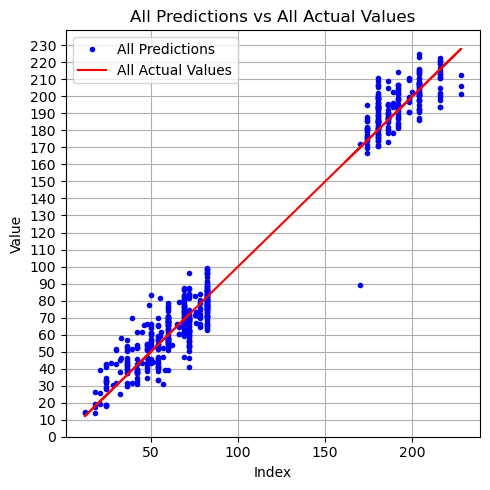

In [450]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming your arrays are already defined
# predictions_84_168, extracted_Y_84_168, predictions, extracted_Y
adjust_predictions = np.array(adjusted_predictions).flatten()
# Combine the prediction arrays
all_predictions = np.concatenate([predictions, predictions_84_168])

# Combine the actual value arrays
all_actual = np.concatenate([extracted_Y, extracted_Y_84_168])

# Create indices for the x-axis
indices = np.arange(len(all_predictions))

# Create a figure and axis object
fig, ax = plt.subplots(figsize=(5, 5))

# Plot all predictions as scatter points
ax.plot(extracted_Y, adjusted_predictions, 'b.', label='All Predictions')

# Plot all actual values as a line
ax.plot(all_actual, all_actual, color='red', label='All Actual Values')

# Set title and labels
ax.set_title('All Predictions vs All Actual Values')
ax.set_xlabel('Index')
ax.set_ylabel('Value')

# Add grid
ax.grid(True)

# Set y-axis ticks to be in multiples of 10
y_ticks = np.arange(0, max(np.max(all_predictions), np.max(all_actual)) + 10, 10)
ax.set_yticks(y_ticks)

# Add legend
ax.legend()

# Adjust the layout and display the plot
plt.tight_layout()
plt.show()


In [538]:
import numpy as np

def adjust_predictions(predictions):
    # Convert predictions to a numpy array if it isn't already
    predictions = np.array(predictions)
    
    # Create a copy of predictions to adjust
    adjusted_predictions = np.copy(predictions)
    
    # Apply adjustments based on the specified ranges
    adjusted_predictions[(predictions >= 170) & (predictions < 180)] -= 15
    adjusted_predictions[(predictions >= 160) & (predictions < 170)] -= 17
    #adjusted_predictions[predictions < 40] -= 20
    #adjusted_predictions[(predictions >= 170) & (predictions < 180)] -= 12
    #
    adjusted_predictions[(predictions >= 150) & (predictions < 160)] -= 10
    #adjusted_predictions[(predictions >= 140) & (predictions < 150)] += 5
    adjusted_predictions[(predictions >= 90) & (predictions < 100)] += 5
    #adjusted_predictions[(predictions >= 80) & (predictions < 90)] += 17
    #adjusted_predictions[(predictions >= 130) & (predictions < 140)] -= 3
    adjusted_predictions[(predictions >= 110) & (predictions < 120)] -= 5
    adjusted_predictions[(predictions >= 100) & (predictions < 110)] -= 8
    #adjusted_predictions[(predictions >= 80) & (predictions < 90)] += 15
    # Add more conditions as needed for other ranges

    return np.array(adjusted_predictions).flatten()

# Example usage
#predictions = np.array([30, 45, 55, 65, 25, 48])
adjusted_predictions2 = adjust_predictions(predictions_84_168)

#print("Original Predictions:", predictions)
print("Adjusted Predictions:", adjusted_predictions2)


Adjusted Predictions: [144.55339 134.4671  143.97862 ... 137.79881 130.34554 147.83012]


In [456]:
# Compute the slope and intercept
m, b = np.polyfit(extracted_Y_84_168, adjusted_predictions2, 1)
print(m)
print(b)

0.6069083558134689
49.42660208812663


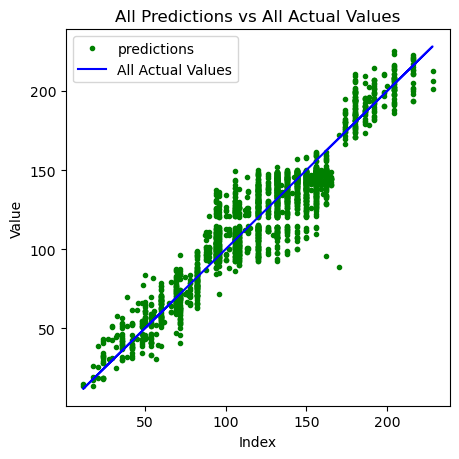

In [544]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming your arrays are already defined
# predictions_84_168, extracted_Y_84_168, predictions, extracted_Y

# Combine the prediction arrays
all_predictions = np.concatenate([adjusted_predictions, adjusted_predictions2])

# Combine the actual value arrays
all_actual = np.concatenate([extracted_Y, extracted_Y_84_168])

# Create indices for the x-axis
indices = np.arange(len(all_predictions))

# Create a figure and axis object
fig, ax = plt.subplots(figsize=(4.7, 4.7))

# Plot all predictions as scatter points
ax.plot(all_actual, all_predictions, 'g.', label = 'predictions')

# Plot all actual values as a line
ax.plot(all_actual, all_actual, color='blue', label='All Actual Values')
#ax.grid(True)

# Set y-axis ticks to be in multiples of 10
#y_ticks = np.arange(0, max(np.max(all_predictions), np.max(all_actual)) + 10, 10)
#ax.set_yticks(y_ticks)
# Set title and labels
ax.set_title('All Predictions vs All Actual Values')
ax.set_xlabel('Index')
ax.set_ylabel('Value')

# Add legend
ax.legend()

# Adjust the layout and display the plot
plt.tight_layout()
plt.show()

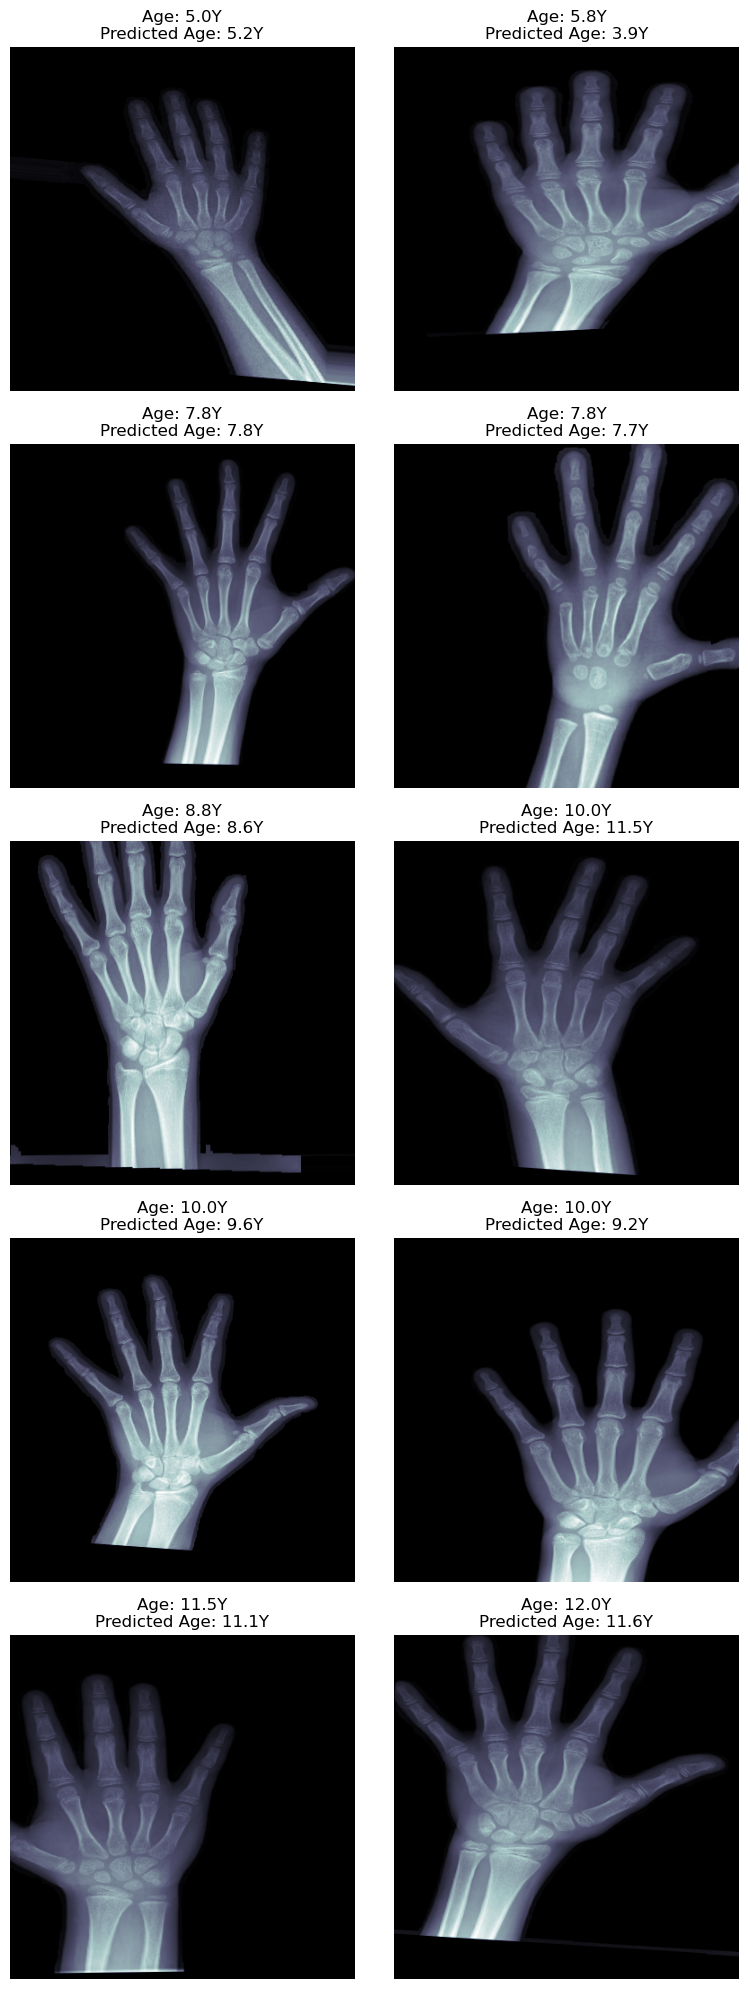

In [478]:
import numpy as np
import matplotlib.pyplot as plt

# Filter indices for ages between 1 and 12 years
# Convert ages to years
test_Y_years = all_actual / 12.0
age_filter = (test_Y_years >= 1) & (test_Y_years <= 12)
filtered_indices = np.where(age_filter)[0]

# Randomly select 10 indices (or fewer if there aren't that many)
num_samples = min(10, len(filtered_indices))
selected_indices = np.random.choice(filtered_indices, size=num_samples, replace=False)

# Sort the selected indices by actual age for a more organized display
selected_indices = selected_indices[np.argsort(test_Y_years[selected_indices])]

# Plotting
fig, m_axs = plt.subplots(5, 2, figsize=(8, 20))

for (idx, c_ax) in zip(selected_indices, m_axs.flatten()):
    c_ax.imshow(test_X[idx, :, :, 0], cmap='bone')
    c_ax.set_title(f'Age: {test_Y_years[idx]:.1f}Y\nPredicted Age: {all_predictions[idx]/12.0:.1f}Y')
    c_ax.axis('off')

# Remove any unused subplots
for idx in range(len(selected_indices), 10):
    fig.delaxes(m_axs.flatten()[idx])

fig.tight_layout()
# fig.savefig('random_sample_predictions.png', dpi=300)
plt.show()

In [541]:
# Define the age range in months
age_min = 9
age_max = 90
absolute_errors = 0
adjusted_pred_Y = all_predictions
# Filter indices where test_Y_months is within the age range
age_filter = (all_actual >= age_min) & (all_actual <= age_max)
filtered_test_Y = all_actual[age_filter]
filtered_adjusted_pred_Y = adjusted_pred_Y[age_filter]
for i in range(len(filtered_adjusted_pred_Y)):
# Calculate the absolute errors for the filtered data
    absolute_errors += np.abs(filtered_adjusted_pred_Y[i] - filtered_test_Y[i])

# Compute the Mean Absolute Error (MAE)
mae = absolute_errors / len(filtered_adjusted_pred_Y)

# Print the MAE
print(f"Mean Absolute Error (MAE) for ages between {age_min} and {age_max} months: {float(mae):.2f} months")

# If needed, convert MAE to years
mae_years = mae / 12.0
print(f"Mean Absolute Error (MAE) for ages between {age_min} and {age_max} months: {float(mae_years):.2f} years")

Mean Absolute Error (MAE) for ages between 9 and 90 months: 8.36 months
Mean Absolute Error (MAE) for ages between 9 and 90 months: 0.70 years
